<a href="https://colab.research.google.com/github/prab-tri/demo/blob/master/ICP12_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ICP12 - Python and Deep Learning**

**Created by - Prabhanjan Trivedi**

In [40]:
#importing all important libraries
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from sklearn.preprocessing import LabelEncoder
from keras.models import model_from_json
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import TensorBoard
from time import time

In [2]:
#uploading the file to google colab
from google.colab import files
files.upload()

Saving Sentiment.csv to Sentiment.csv


{'Sentiment.csv': b'id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone\n1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0,,I_Am_Kenzi,,5,,,RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate,,2015-08-07 09:54:46 -0700,629697200650592256,,Quito\n2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0,,PeacefulQuest,,26,,,RT @ScottWalker: Didn\'t catch the full #GOPdebate last night. Here are some of Scott\'s best lines in 90 seconds. #Walker16 http://t.co/ZSfF\xe2\x80\xa6,,2015-08-07 09:54:46 -0700,629697199560069120,,\n3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,,PussssyCroook,,27,,,RT @TJMShow: No mention of Tamir Rice and th

In [12]:
data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

text sentiment
0  RT @NancyLeeGrahn: How did everyone feel about...   Neutral
1  RT @ScottWalker: Didn't catch the full #GOPdeb...  Positive
2  RT @TJMShow: No mention of Tamir Rice and the ...   Neutral
3  RT @RobGeorge: That Carly Fiorina is trending ...  Positive
4  RT @DanScavino: #GOPDebate w/ @realDonaldTrump...  Positive

In [13]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))
data.head(5)

text sentiment
0  rt nancyleegrahn how did everyone feel about t...   Neutral
1  rt scottwalker didnt catch the full gopdebate ...  Positive
2  rt tjmshow no mention of tamir rice and the go...   Neutral
3  rt robgeorge that carly fiorina is trending  h...  Positive
4  rt danscavino gopdebate w realdonaldtrump deli...  Positive

In [14]:
print(data[data['sentiment'] == 'Positive'].size)
print(data[data['sentiment'] == 'Negative'].size)

4472
16986


In [15]:
for idx, row in data.iterrows():
    row[0] = row[0].replace('rt', ' ')

In [16]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)

X = pad_sequences(X)
print(X)

[[   0    0    0 ...   51 1039    1]
 [   0    0    0 ... 1577 1356  847]
 [   0    0    0 ...   10  696  518]
 ...
 [   0    0    0 ...   68   62    3]
 [   0    0    0 ... 1112 1588   81]
 [   0    0    0 ...  196    3  880]]


In [17]:
embed_dim = 128
lstm_out = 196
def createmodel():
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

In [18]:
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['sentiment'])
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [19]:
batch_size = 32
model = createmodel()
model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2)
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
print(score)
print(acc)
print(model.metrics_names)

Epoch 1/5
291/291 - 34s - loss: 0.8239 - accuracy: 0.6487
Epoch 2/5
291/291 - 34s - loss: 0.6806 - accuracy: 0.7089
Epoch 3/5
291/291 - 34s - loss: 0.6037 - accuracy: 0.7457
Epoch 4/5
291/291 - 33s - loss: 0.5605 - accuracy: 0.7667
Epoch 5/5
291/291 - 34s - loss: 0.5153 - accuracy: 0.7921
144/144 - 2s - loss: 0.8396 - accuracy: 0.6547
0.8395521640777588
0.6546527147293091
['loss', 'accuracy']


In [20]:
#convert model to json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [21]:
#Load model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [22]:
#evaluate model
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X, y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1] * 100))

accuracy: 77.19%


In [25]:
tweet = ['A lot of good things are happening. We are respected again throughout the world, and thats a great thing.@realDonaldTrump']

# vectorizing the tweet by the pre-fitted tokenizer instance
tweet = tokenizer.texts_to_sequences(tweet)

# padding the tweet to have exactly the same shape as `embedding_2` input
tweet = pad_sequences(tweet, maxlen=28, dtype='int32', value=0)
print(tweet)
sentiment = model.predict(tweet, batch_size=1, verbose=2)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   7 445   5 146 292  35  30
   35 371   2 349   8 262   7 153 265  23]]
1/1 - 0s
[0.11246884 0.02869177 0.8588394 ]


In [26]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=32)
# history = model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2,  callbacks=[tensorborad])
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
from keras.models import load_model
# model.save('model.h5')
print(score)
print(acc)

Epoch 1/5
291/291 [==============================] - 38s 131ms/step - loss: 0.4735 - accuracy: 0.8102 - val_loss: 0.8884 - val_accuracy: 0.6614
Epoch 2/5
291/291 [==============================] - 38s 130ms/step - loss: 0.4392 - accuracy: 0.8191 - val_loss: 0.9714 - val_accuracy: 0.6549
Epoch 3/5
291/291 [==============================] - 38s 130ms/step - loss: 0.4020 - accuracy: 0.8378 - val_loss: 0.9662 - val_accuracy: 0.6678
Epoch 4/5
291/291 [==============================] - 38s 130ms/step - loss: 0.3762 - accuracy: 0.8491 - val_loss: 1.1703 - val_accuracy: 0.6361
Epoch 5/5
291/291 [==============================] - 38s 130ms/step - loss: 0.3467 - accuracy: 0.8624 - val_loss: 1.1741 - val_accuracy: 0.6533
144/144 - 2s - loss: 1.1741 - accuracy: 0.6533
1.174059510231018
0.653342068195343


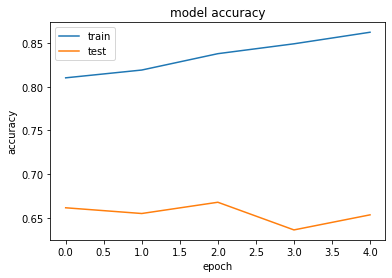

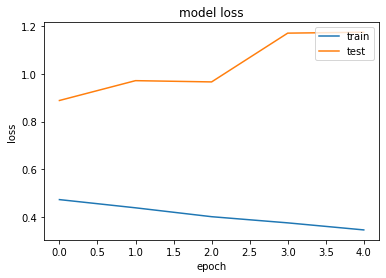

In [27]:
#Answer for Bonus Question 
#accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Question 2  - Apply GridSearchCV on the source code provided in the class.**


In [30]:
batch_size = 40
model = KerasClassifier(build_fn=createmodel,verbose=0)

In [31]:
epochs = [1, 2, 3]
param_grid= dict(epochs=epochs)
grid  = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result= grid.fit(X_train, Y_train,batch_size=40)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.673301 using {'epochs': 3}


**Question 3 - Apply the code on spam data set available in the source code (text classification on the spam.csv data set)**

In [32]:
#uploading the file to google colab
from google.colab import files
files.upload()

Saving spam.csv to spam.csv


{'spam.csv': b'v1,v2,,,\r\nham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,\r\nham,Ok lar... Joking wif u oni...,,,\r\nspam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C\'s apply 08452810075over18\'s,,,\r\nham,U dun say so early hor... U c already then say...,,,\r\nham,"Nah I don\'t think he goes to usf, he lives around here though",,,\r\nspam,"FreeMsg Hey there darling it\'s been 3 week\'s now and no word back! I\'d like some fun you up for it still? Tb ok! XxX std chgs to send, \xe5\xa31.50 to rcv",,,\r\nham,Even my brother is not like to speak with me. They treat me like aids patent.,,,\r\nham,As per your request \'Melle Melle (Oru Minnaminunginte Nurungu Vettam)\' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,\r\nspam,WINNER!! As a valued network customer you have been selected to rece

In [43]:
data = pd.read_csv('spam.csv',encoding='latin-1')
data.head(5)

v1  ... Unnamed: 4
0   ham  ...        NaN
1   ham  ...        NaN
2  spam  ...        NaN
3   ham  ...        NaN
4   ham  ...        NaN

[5 rows x 5 columns]

In [44]:
data = data[['v2','v1']]
data['v2'] = data['v2'].apply(lambda x: x.lower())
data['v2'] = data['v2'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))
data.head(5)

v2    v1
0  go until jurong point crazy available only in ...   ham
1                            ok lar joking wif u oni   ham
2  free entry in 2 a wkly comp to win fa cup fina...  spam
3        u dun say so early hor u c already then say   ham
4  nah i dont think he goes to usf he lives aroun...   ham

In [45]:
for idx, row in data.iterrows():
    row[0] = row[0].replace('rt', ' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['v2'].values)
X = tokenizer.texts_to_sequences(data['v2'].values)
#print(X)
X = pad_sequences(X)
embed_dim = 128
lstm_out = 196

In [46]:
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['v1'])
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3733, 152) (3733, 2)
(1839, 152) (1839, 2)


In [47]:
def createmodel():
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

In [51]:
batch_size = 32
model = createmodel()

tensorborad = TensorBoard(log_dir="logs/{}".format(time()))

# Fit the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs = 5, batch_size=batch_size, verbose = 2,  callbacks=[tensorborad])
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
from keras.models import load_model
model.save('my_model.h5')
print(score)
print(acc)

Epoch 1/5
117/117 - 81s - loss: 0.1806 - accuracy: 0.9389 - val_loss: 0.0724 - val_accuracy: 0.9777
Epoch 2/5
117/117 - 80s - loss: 0.0498 - accuracy: 0.9855 - val_loss: 0.0638 - val_accuracy: 0.9837
Epoch 3/5
117/117 - 80s - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.0687 - val_accuracy: 0.9837
Epoch 4/5
117/117 - 80s - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.0677 - val_accuracy: 0.9848
Epoch 5/5
117/117 - 80s - loss: 0.0087 - accuracy: 0.9979 - val_loss: 0.0827 - val_accuracy: 0.9815
58/58 - 5s - loss: 0.0827 - accuracy: 0.9815
0.08270538598299026
0.9815117120742798


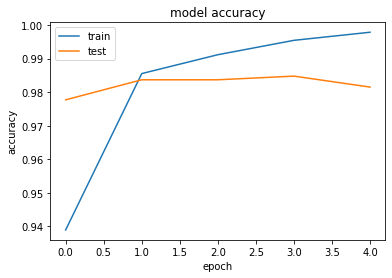

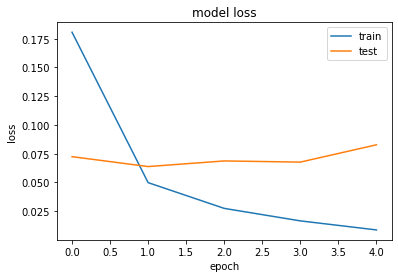

In [52]:
#bonus question
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()